## This will be the main.py file

In [19]:
import sys, os
sys.path.insert(1, "../..")

import json
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot
from rdsutils.data_waterfall import DataWaterfallReport 

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import src.train as train
import src.governance as gvrn
import src.preprocessing.customer_utils as cu
import src.preprocessing.utils as pu

### Load config
---

TODO: sent updated config to s3

In [21]:
with open("../../config.json","r") as f:
    config = json.load(f)
    
SEED = config["model_params"]["seed"]
TARGET_COL = "target"
INDETERMINATE_COL = config["indeterminate_col"]

### Data
---

In [22]:
modeling_df, valid_dfs, test_dfs = train.prep_data(config, TARGET_COL)

In [23]:
base_dir = config["base_dir"]
artifact_path = config["artifact_path"]
govn_path = os.path.join(base_dir, artifact_path, "governance") 

context = {"modeling_df": modeling_df,
           "valid_dfs": valid_dfs,
           "test_dfs": test_dfs,
           "config": config,
           "target_col": "target",
           "seed": config["model_params"]["seed"],
           "indeterminate_col": config["indeterminate_col"],
           "model_name": config["model_name"],
           "govn_path": govn_path,
           "pred_cols": []}

In [24]:
# setting up preprocess fns
context["baseline_models"] = train.get_baseline_models(config)
context["baseline_models"]["deposit_v1"]["preprocess"] = None
context["baseline_models"]["customer"]["preprocess"] = cu.preprocess

Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.


In [25]:
result = train.get_baseline_preds(context["baseline_models"],
                                                      modeling_df,
                                                      valid_dfs,
                                                      test_dfs)
modeling_df, valid_dfs, test_dfs, new_cols = result
context["pred_cols"].extend(new_cols)

generating deposit_v1 prediction for modeling_df
generating deposit_v1 prediction for test_df
generating deposit_v1 prediction for test_df
generating customer prediction for modeling_df
generating customer prediction for test_df
generating customer prediction for test_df


In [26]:
config, context = train.train_model(config, context, pu.preprocess)
config, context = train.validate_model(config, context, pu.preprocess)

Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: seed_value
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
[LightGBM] [Warning] seed is set=12345, random_state=12345 will be ignored. Current value: seed=12345
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
generating final model prediction for modeling_df
generating final model prediction for test_df
generating final model prediction for test_df


In [27]:
clf = context["model_object"]
result = train.get_model_preds(clf, modeling_df, 
                               valid_dfs, test_dfs, pu.preprocess)
modeling_df, valid_dfs, test_dfs, new_cols = result
context["pred_cols"].extend(new_cols)

generating final model prediction for modeling_df
generating final model prediction for test_df
generating final model prediction for test_df


preprocessing modeling_df
saving data waterfall
saving hyperparams
saving feature importance
saving model validation performance
saving model object
saving feature importance
saving SHAP


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


saving PDP


26it [00:56,  2.18s/it]


saving WOE
processed  26  num attributes

transformed num 20

saving validation segmented performance


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


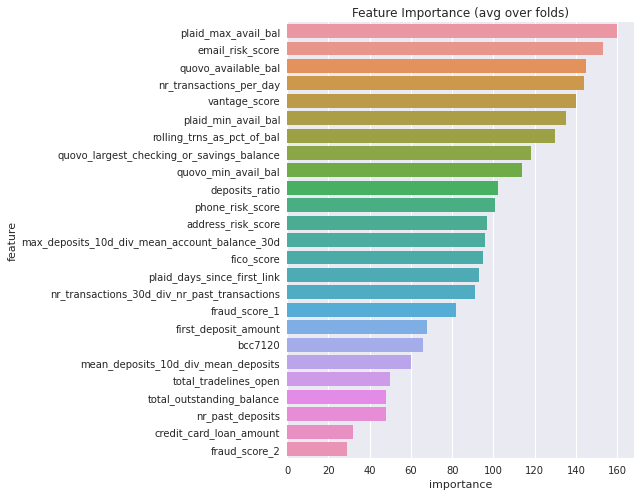

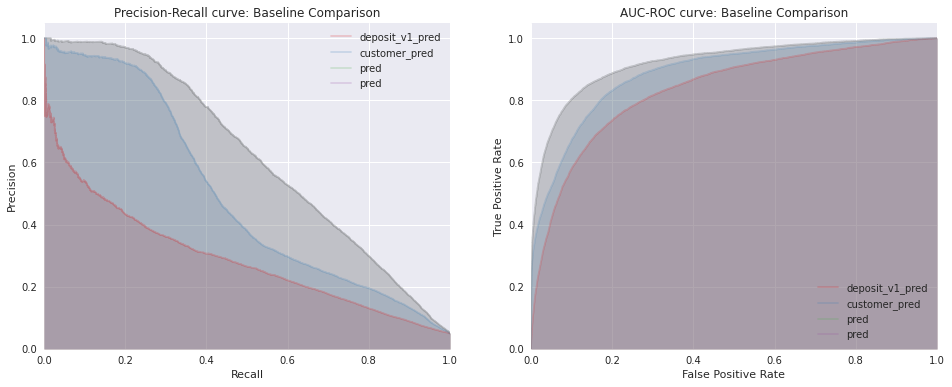

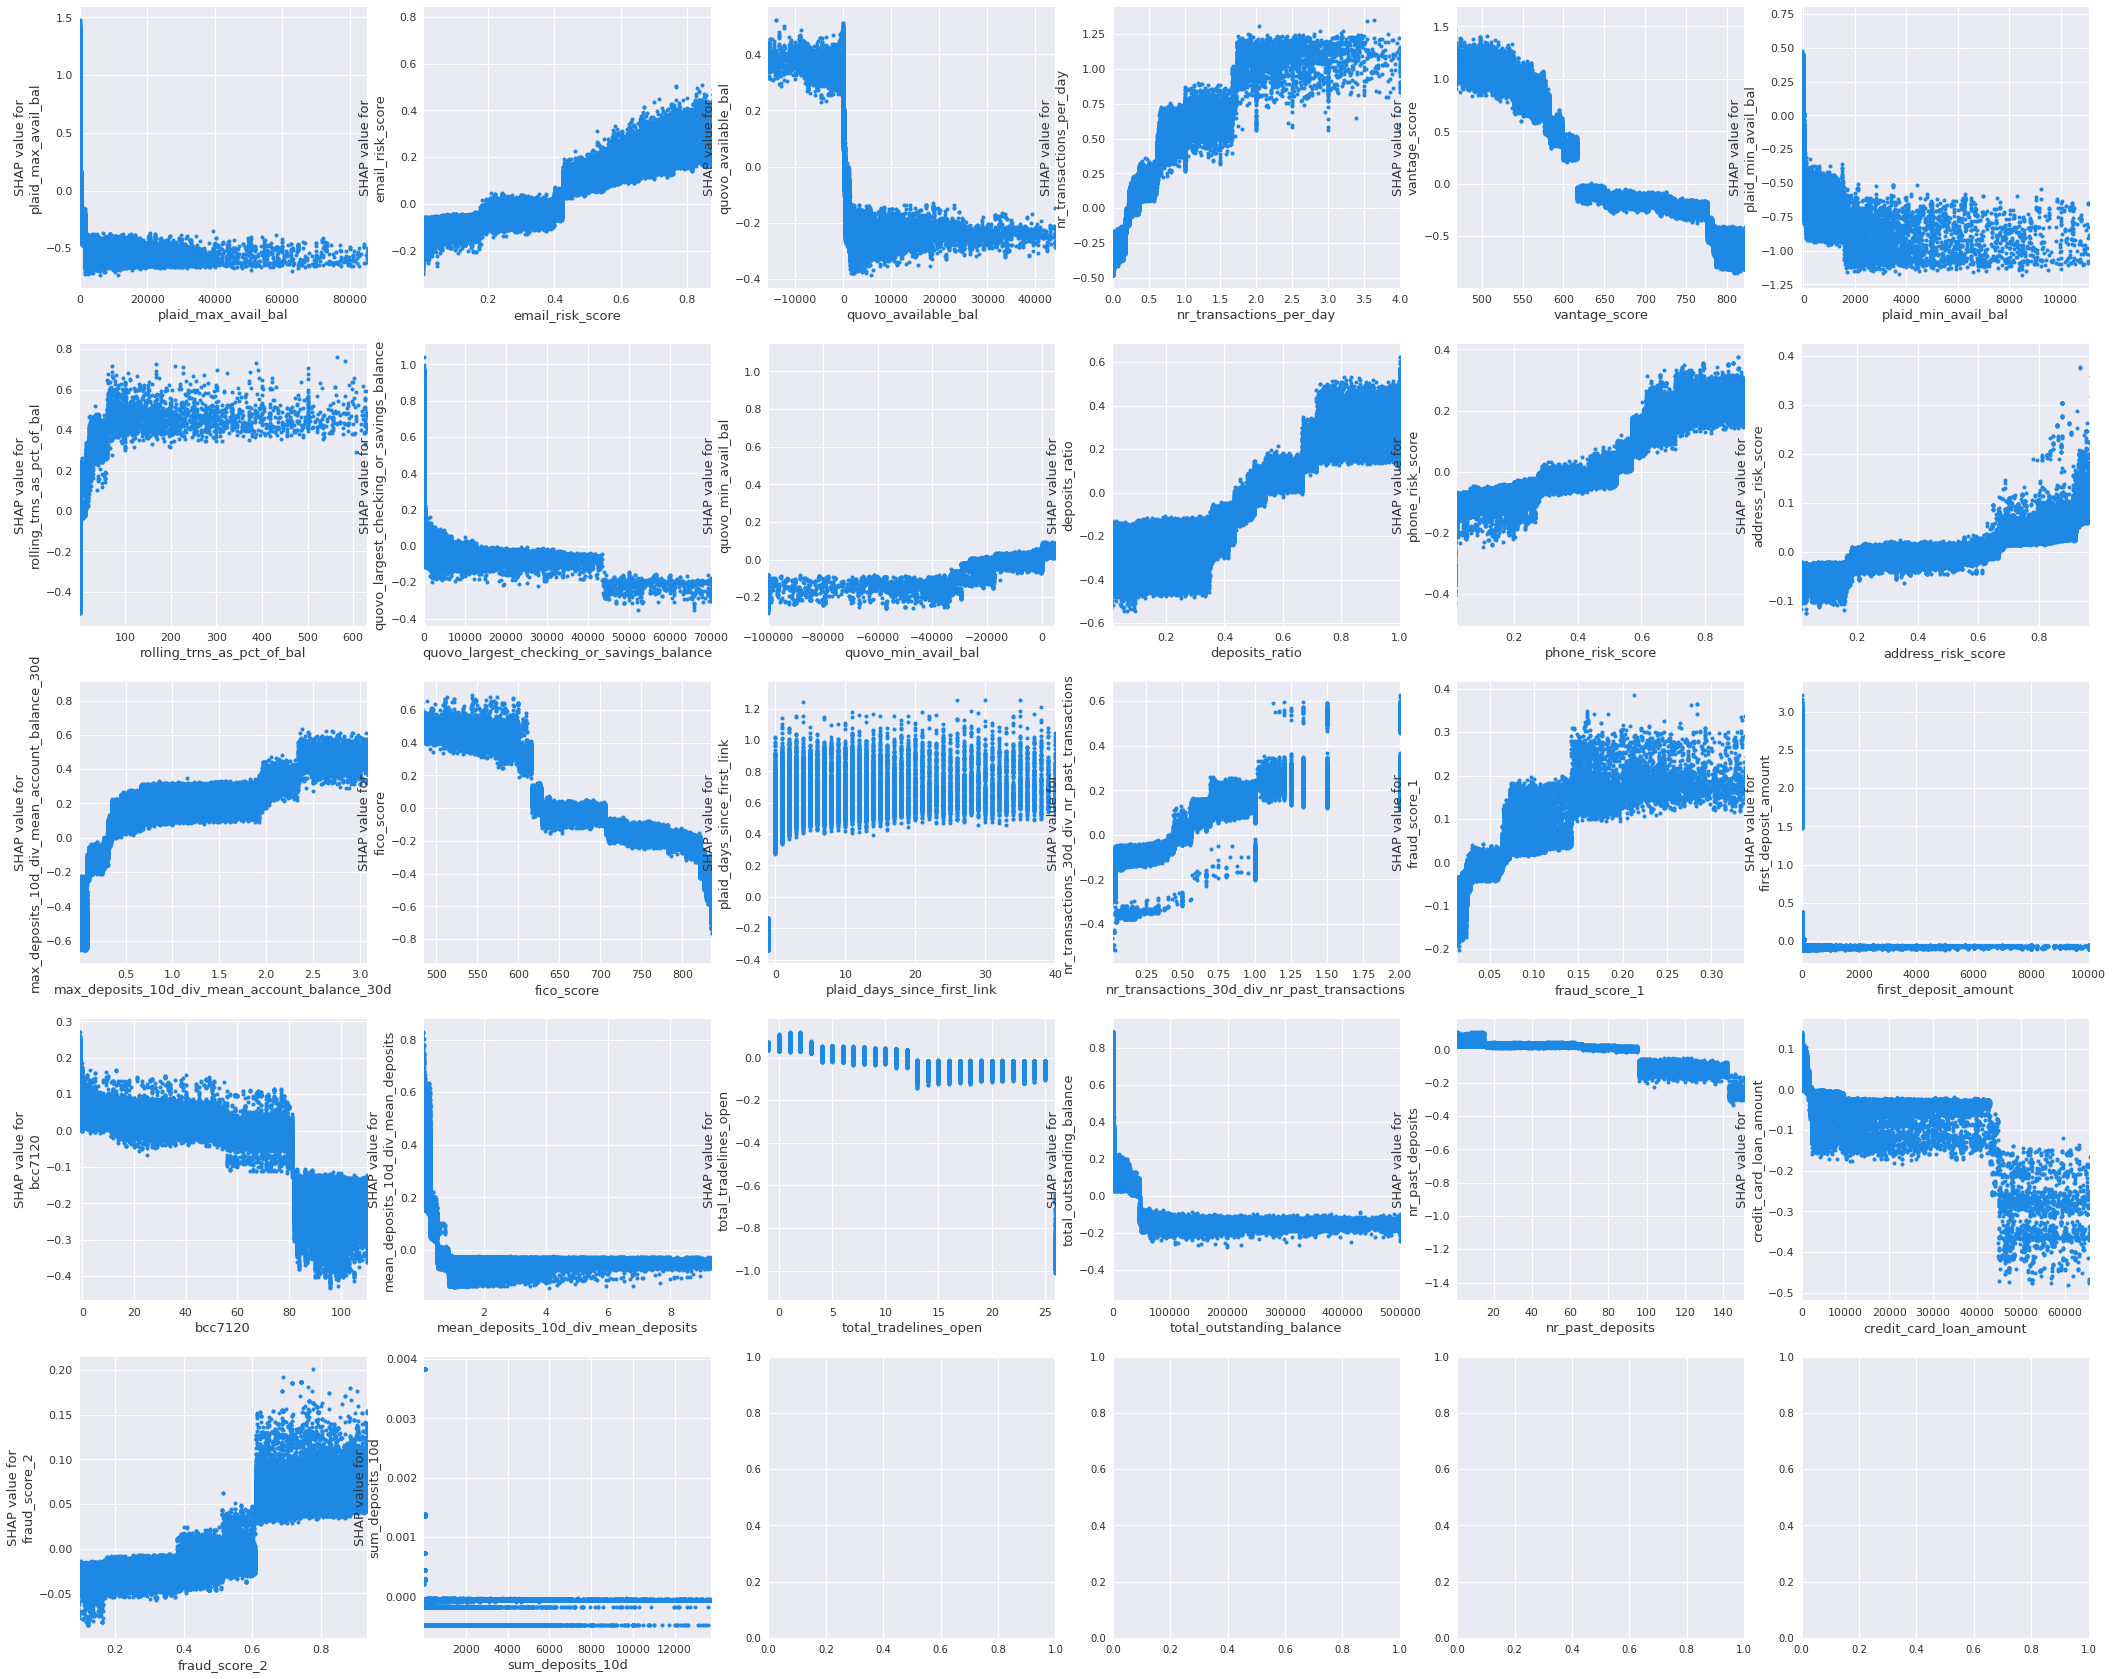

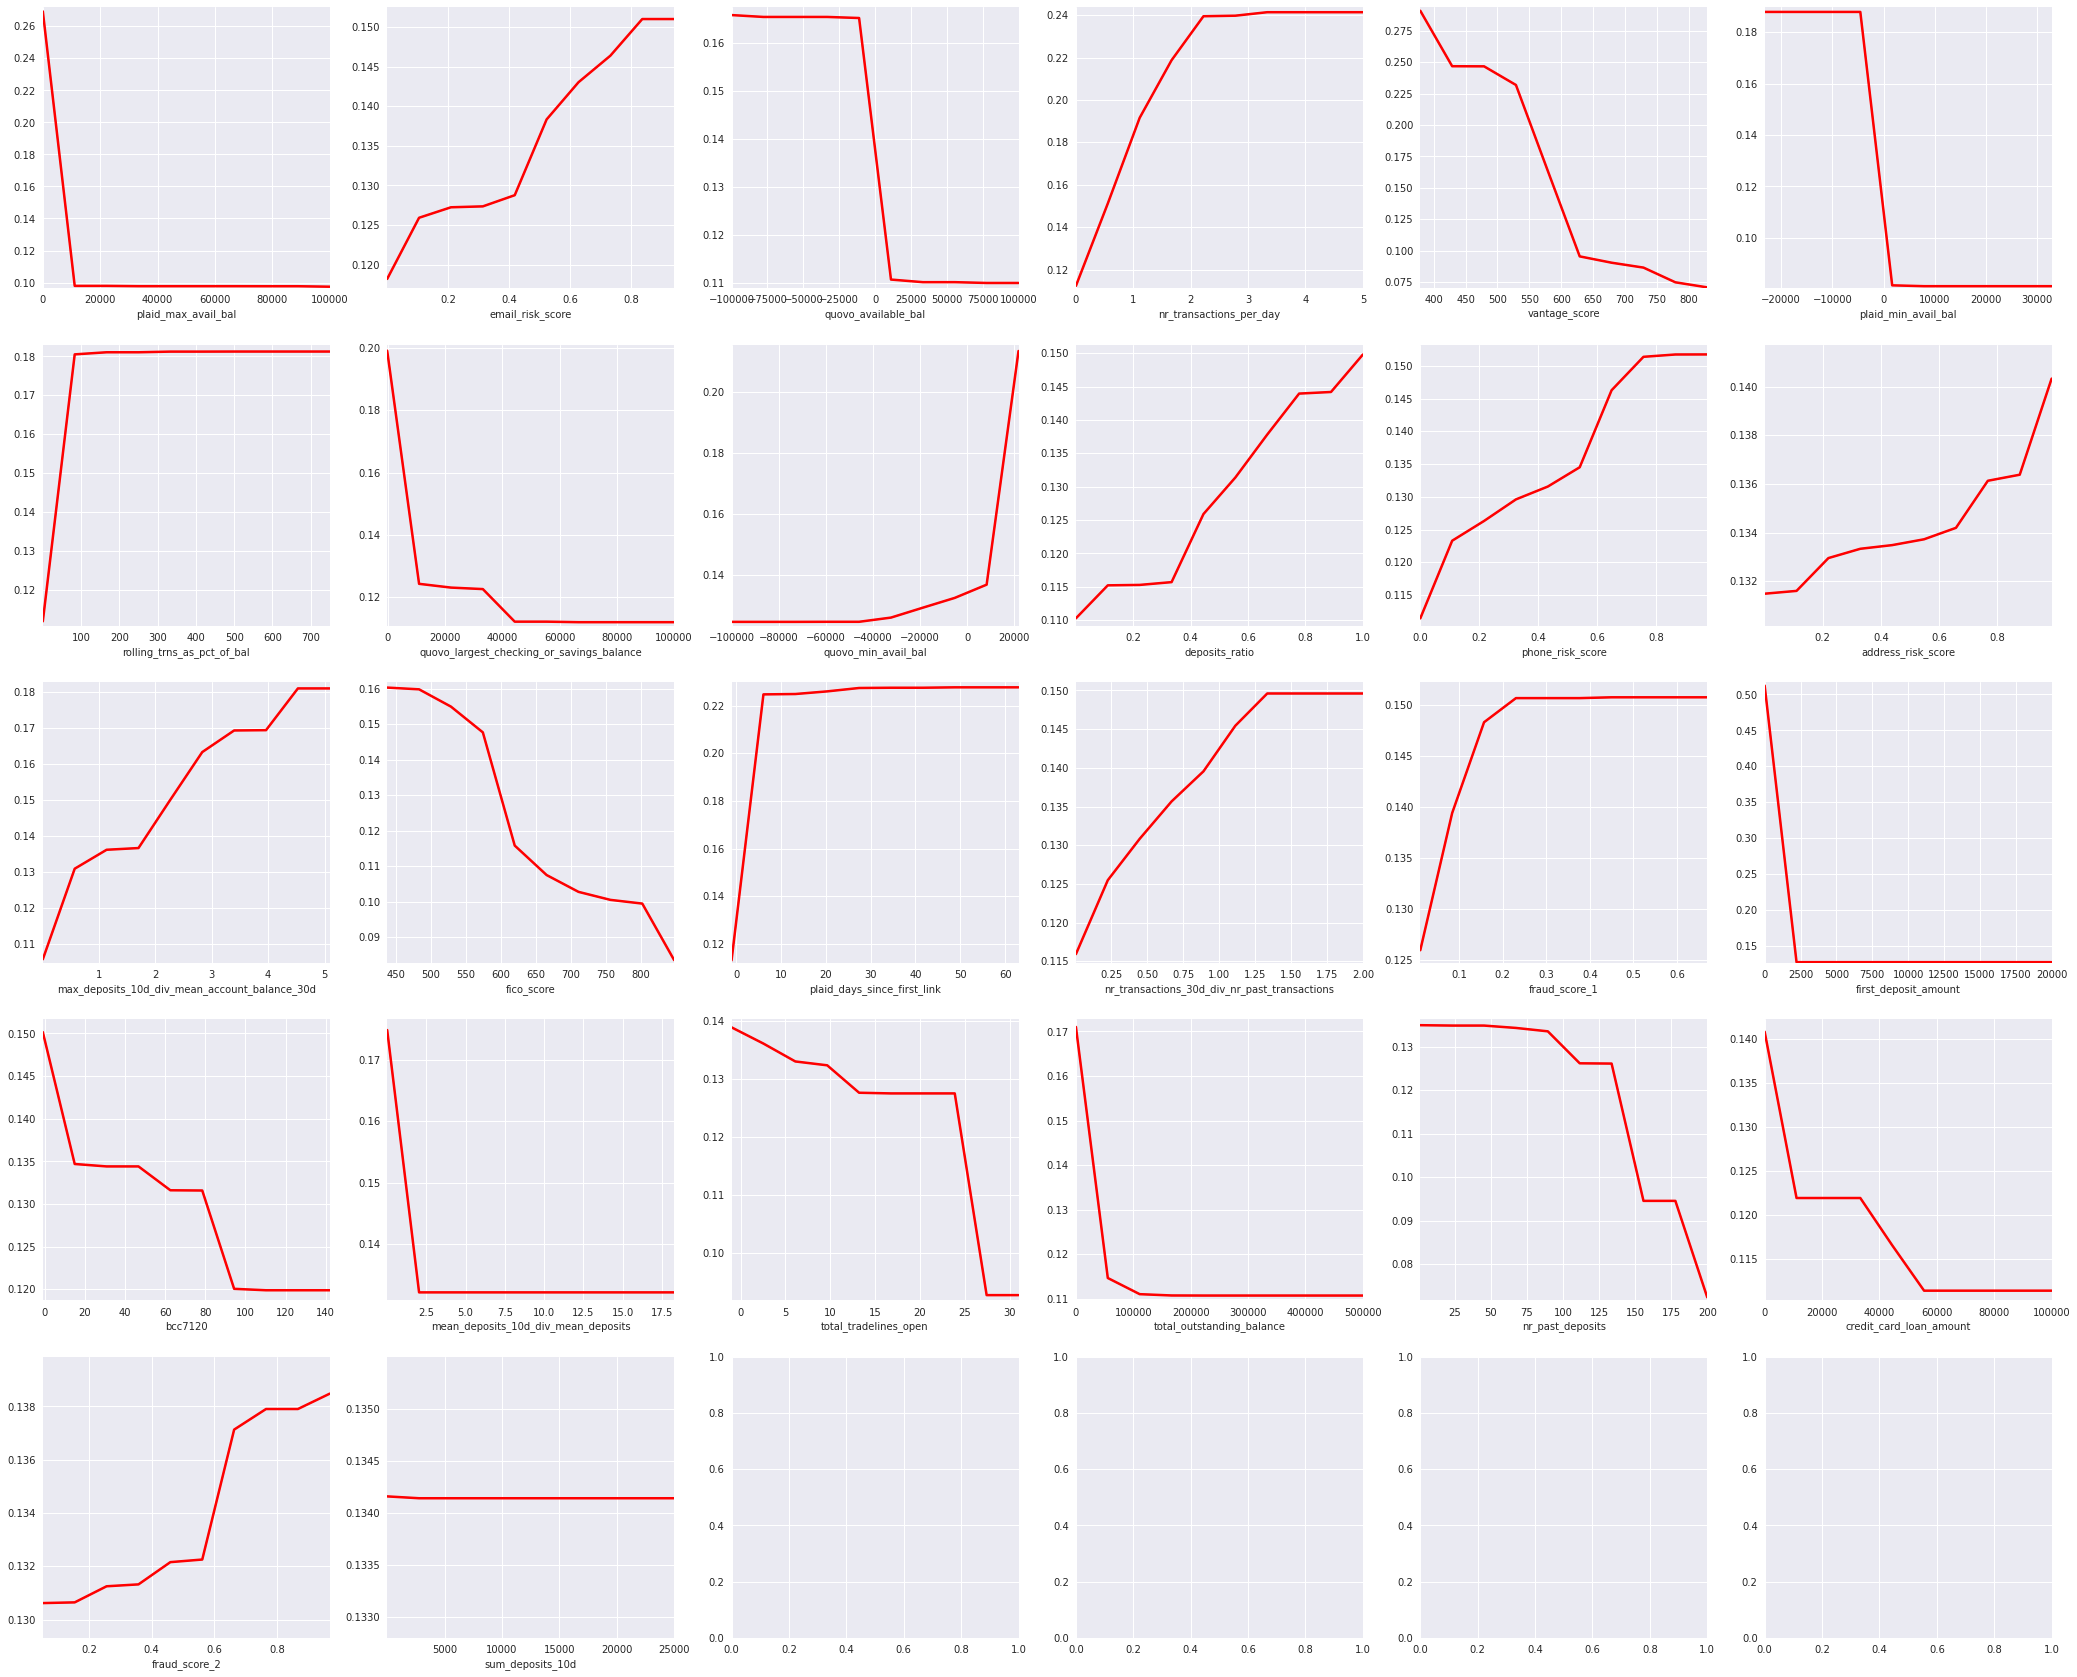

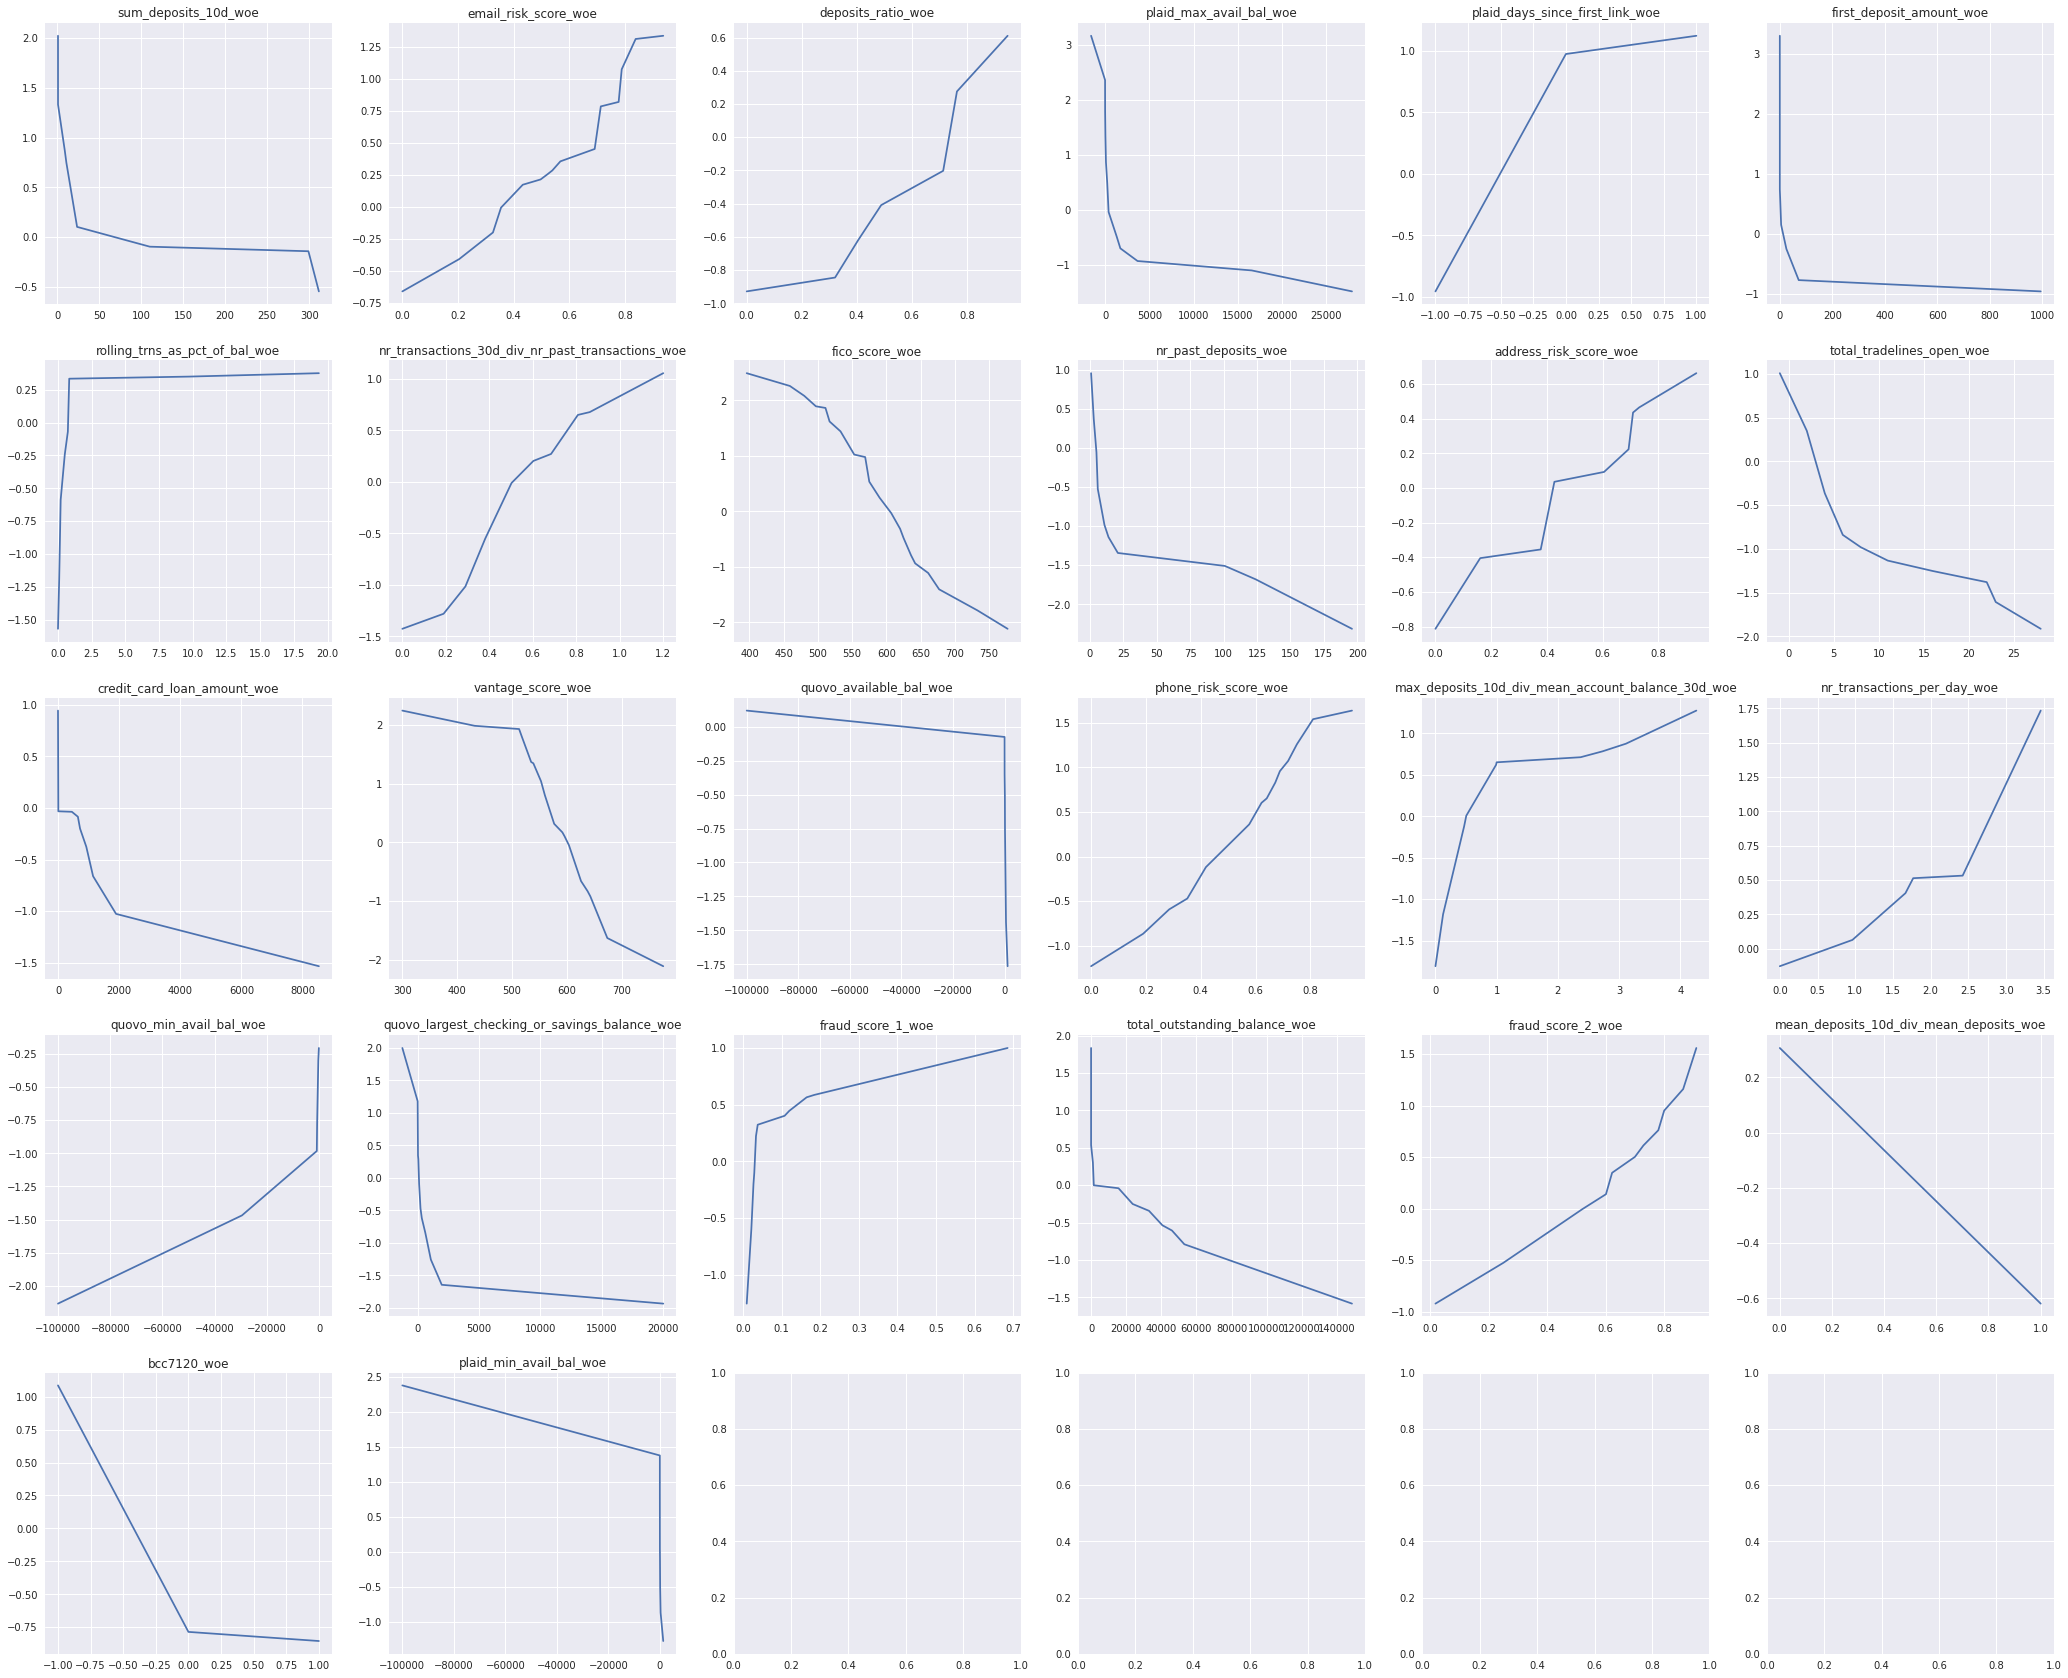

In [30]:
gvrn.save_governance_data(config, context, pu.preprocess)

In [57]:
# data waterfall 

def drop_non_ach(df):
    df = df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]
    return df

def drop_bad_but_pos_balance(df):
    return df[~(df[f'target_10d'] & (df[f'bal_after_10d'] > 0))]

def drop_good_but_has_returns(df):
    condition = (~df['target_10d'] & (df[f'nr_returns_in_next_10d'] > 0))
    return df[~condition]

def drop_good_but_chg_wrt_off(df):
    return df[~(df[f'target_10d'] & ~df['target_10d'])]

def drop_good_but_neg_balance(df):
    return df[~(~df['target_10d'] & (df[f'bal_after_10d'] < 0))]

def drop_good_but_closed_by_risk(df):
    condition = (~df['target_10d'] & df[f'account_closed_by_risk_in_next_10d'])
    return df[~condition]

fns = [drop_non_ach,]
#        drop_bad_but_pos_balance, 
#        drop_good_but_has_returns,
#        drop_good_but_chg_wrt_off,
#        drop_good_but_neg_balance,
#        drop_good_but_closed_by_risk]
wf = DataWaterfallReport(modeling_df, fns, 'is_returned')
report = wf.get_report(True)

In [49]:
import os

base_dir = config["base_dir"]
artifact_path = config["artifact_path"]
govn_path = os.path.join(base_dir, artifact_path, "governance") 
context["govn_path"] = govn_path
os.makedirs(GOVN_PATH, exist_ok=True)

In [17]:
report.to_csv(os.path.join(GOVN_PATH, "data_waterfall.csv"))
report

,# Excluded,# Remain,# False,# True
Starting Population,,112599,108825,3774
Drop Non Ach,0,112599,108825,3774


### Baselines
---

In [18]:
# !pip uninstall scikit-learn -y
# !pip install "scikit-learn==0.22"

In [19]:
context["baseline_models"] = train.get_baseline_models(config)
context["baseline_models"]["deposit_v1"]["preprocess"] = None

import src.preprocessing.customer_utils as cu
context["baseline_models"]["customer"]["preprocess"] = cu.preprocess

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
result = train.get_baseline_preds(context["baseline_models"],
                                                      modeling_df,
                                                      valid_dfs,
                                                      test_dfs)
modeling_df, valid_dfs, test_dfs, new_cols = result
context["pred_cols"].extend(new_cols)

generating deposit_v1 prediction for modeling_df
generating deposit_v1 prediction for test_df
generating deposit_v1 prediction for test_df
generating customer prediction for modeling_df
generating customer prediction for test_df
generating customer prediction for test_df


### Fit Final Model
---

In [21]:
import src.preprocessing.utils as pu

config, context = train.train_model(config, context, pu.preprocess)
config, context = train.validate_model(config, context, pu.preprocess)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: seed_value
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
[LightGBM] [Warning] seed is set=12345, random_state=12345 will be ignored. Current value: seed=12345
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
generating final model prediction for modeling_df
generating final model prediction for test_df
generating final model prediction for test_df


In [ ]:
# import lightgbm as lgb 

# params = config["model_params"].copy()
# params["early_stopping_round"] = None
# features = config["features"]
# if INDETERMINATE_COL in modeling_df:
#     modeling_df = modeling_df[~modeling_df[INDETERMINATE_COL]]

# clf = lgb.LGBMClassifier(**params)
# X = modeling_df[features]
# y = modeling_df[TARGET_COL]
# clf.fit(X, y)

In [24]:
import src.preprocessing.utils as pu
clf = context["model_object"]
result = train.get_model_preds(clf, modeling_df, 
                               valid_dfs, test_dfs, pu.preprocess)
modeling_df, valid_dfs, test_dfs, new_cols = result
context["pred_cols"].extend(new_cols)

generating final model prediction for modeling_df
generating final model prediction for test_df
generating final model prediction for test_df


In [25]:
# check valid model performance, and then order food!!

#### Collect model related info
---
- [x] hyper-params
- [x] feature importance
- [x] model performance table
- [x] model performance plots
- [x] segmented model performance
- [x] model.pickle
- [x] model.txt
- [x] woe
- [x] shap
- [x] pdp


In [26]:
import src.governance as gvrn

In [39]:
modeling_df = pu.preprocess(modeling_df)
PRED_COLS = context["pred_cols"]

In [40]:
# save hyperparameters
gvrn.save_hyperparams(config["model_params"], os.path.join(GOVN_PATH, "model_params.json"), "json")
gvrn.save_hyperparams(config["model_params"], os.path.join(GOVN_PATH, "model_params.csv"), "csv")

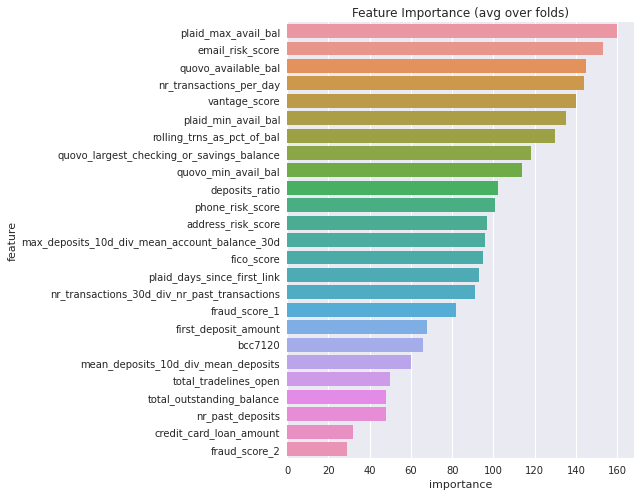

In [41]:
# save feature importance
gvrn.save_feature_importance_plot(clf.feature_name_, clf.feature_importances_, os.path.join(GOVN_PATH, "feature_importance.png"))

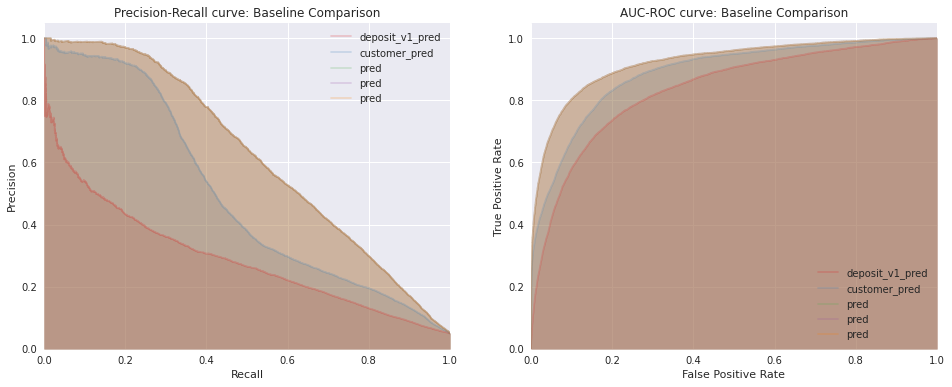

In [42]:
gvrn.save_valid_performance_plots(valid_dfs, TARGET_COL, PRED_COLS, os.path.join(GOVN_PATH, "oot_validation"))

In [43]:
# model and model.txt
gvrn.save_lgbm_txt(clf, os.path.join(govn_path, "model.txt"))
gvrn.pickle_obj(clf, os.path.join(govn_path, "model.pkl"))

In [44]:
features_by_imp = gvrn.get_feature_by_importance(clf)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


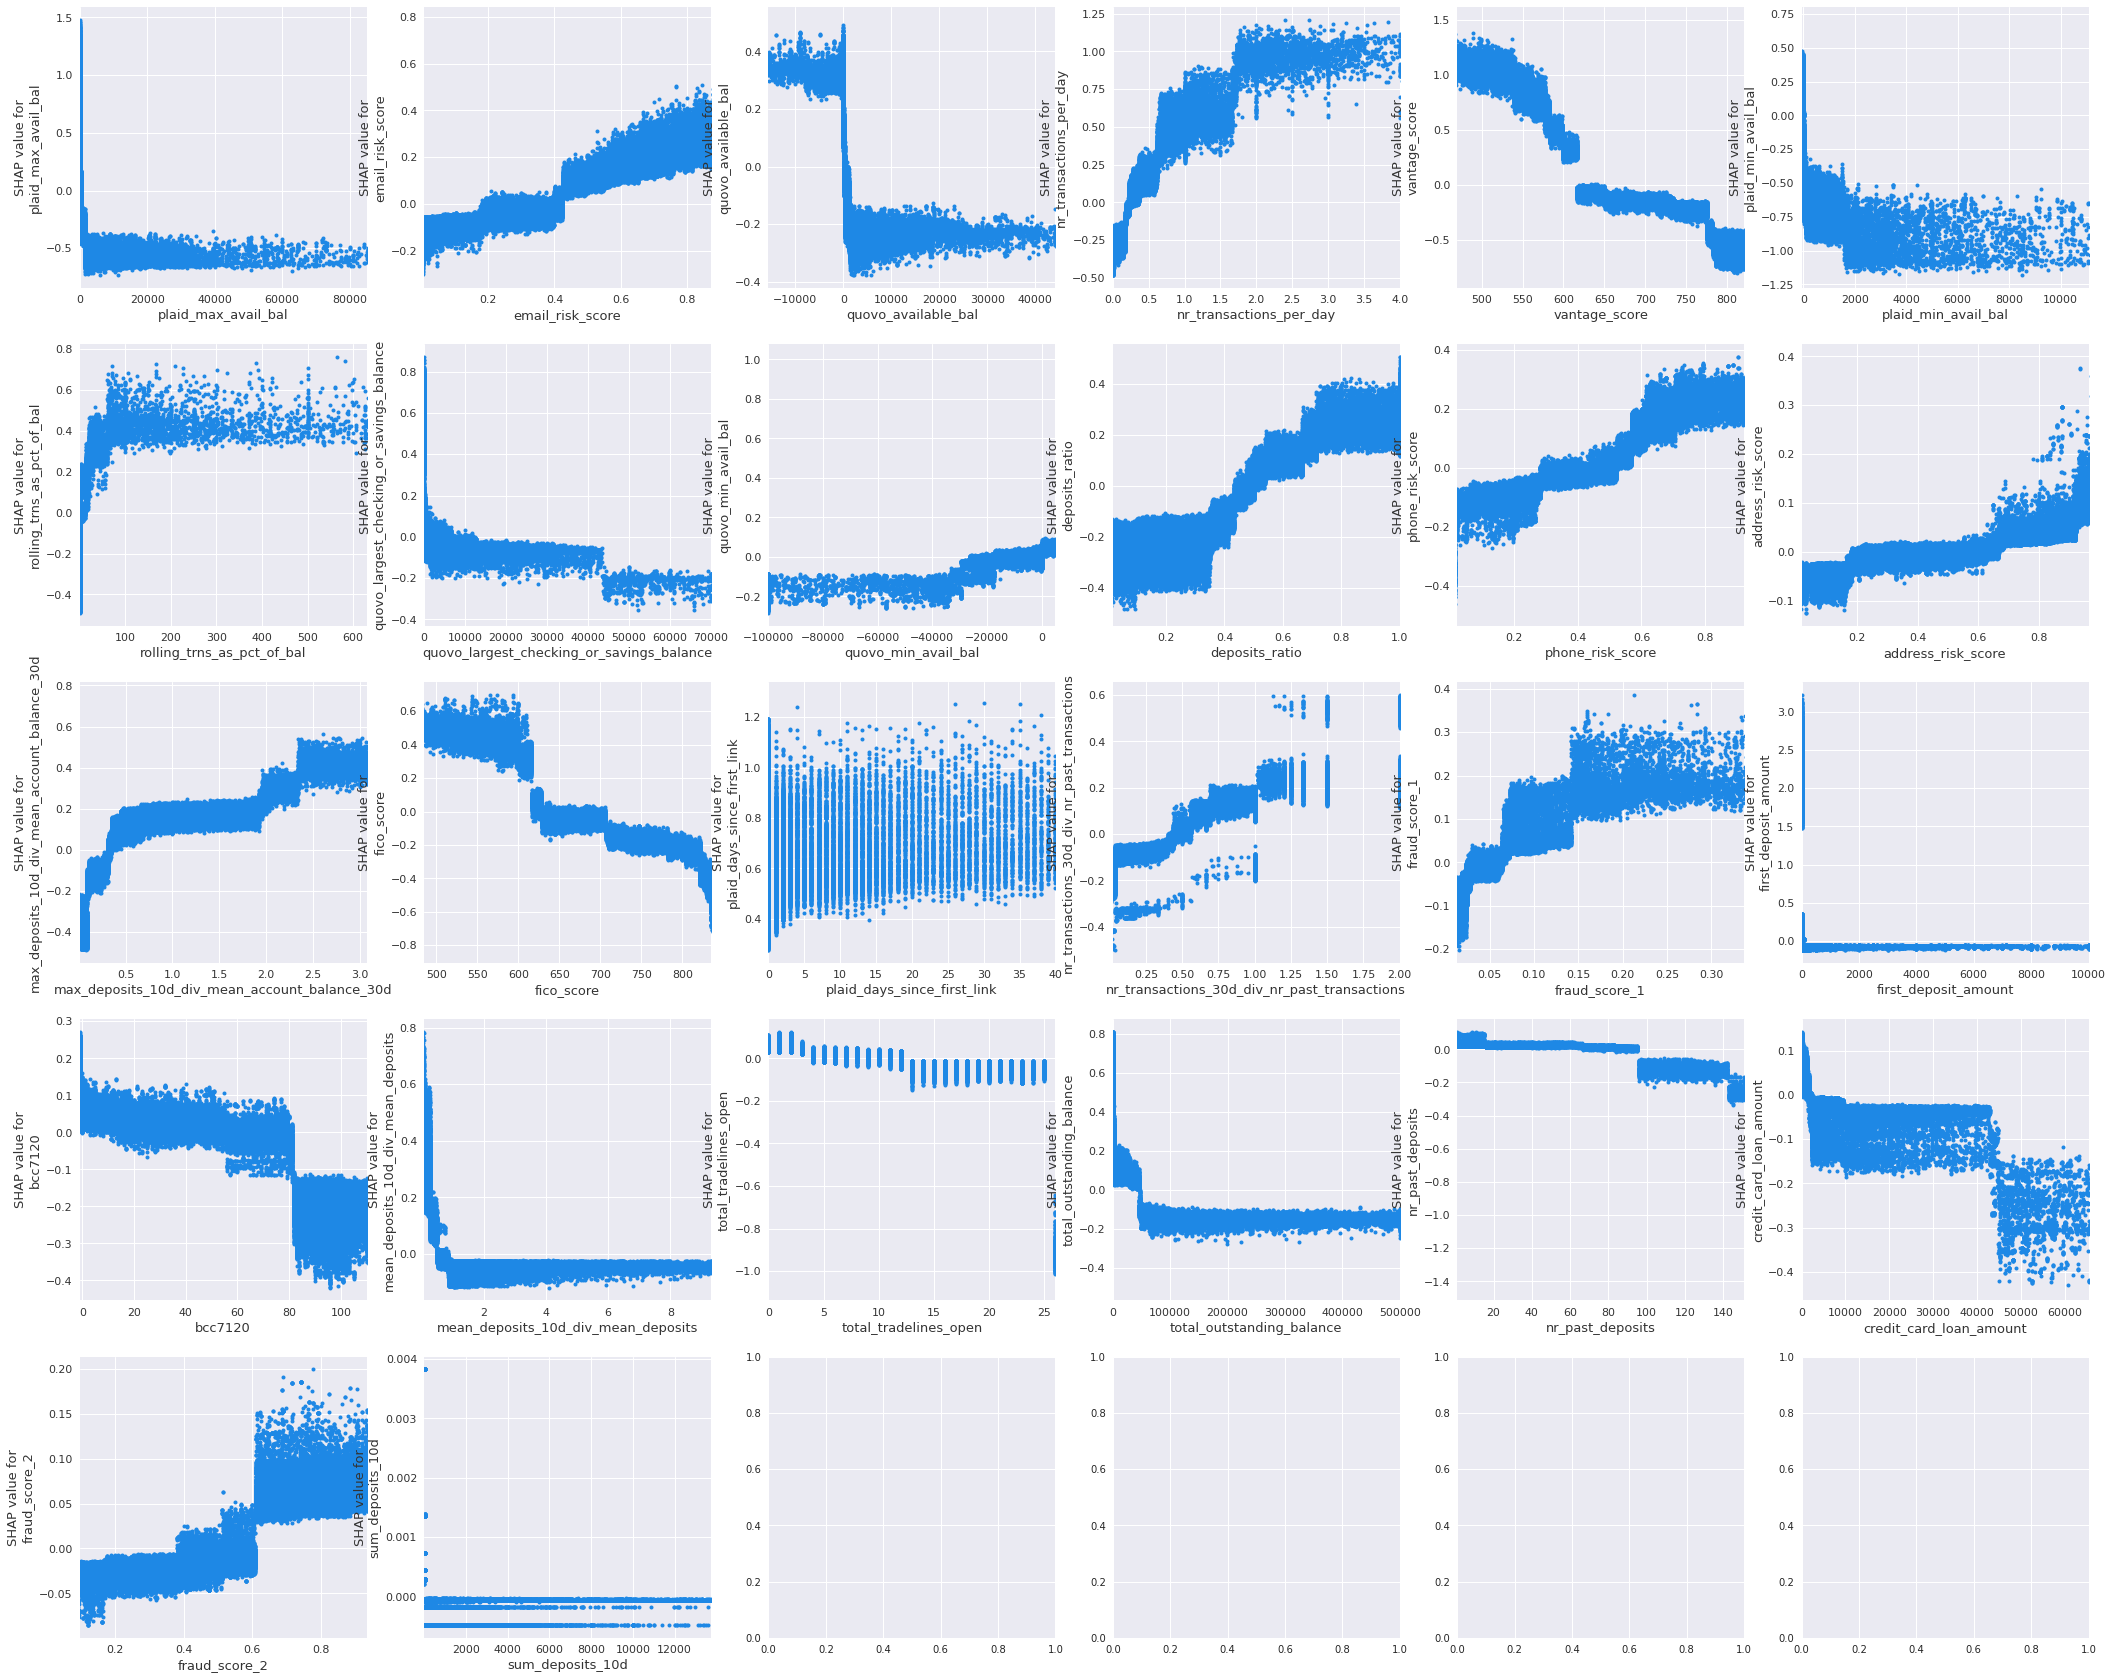

In [45]:
gvrn.save_shap_dependence(clf, modeling_df, features_by_imp,
                     os.path.join(govn_path, "shap"))

26it [00:51,  1.99s/it]


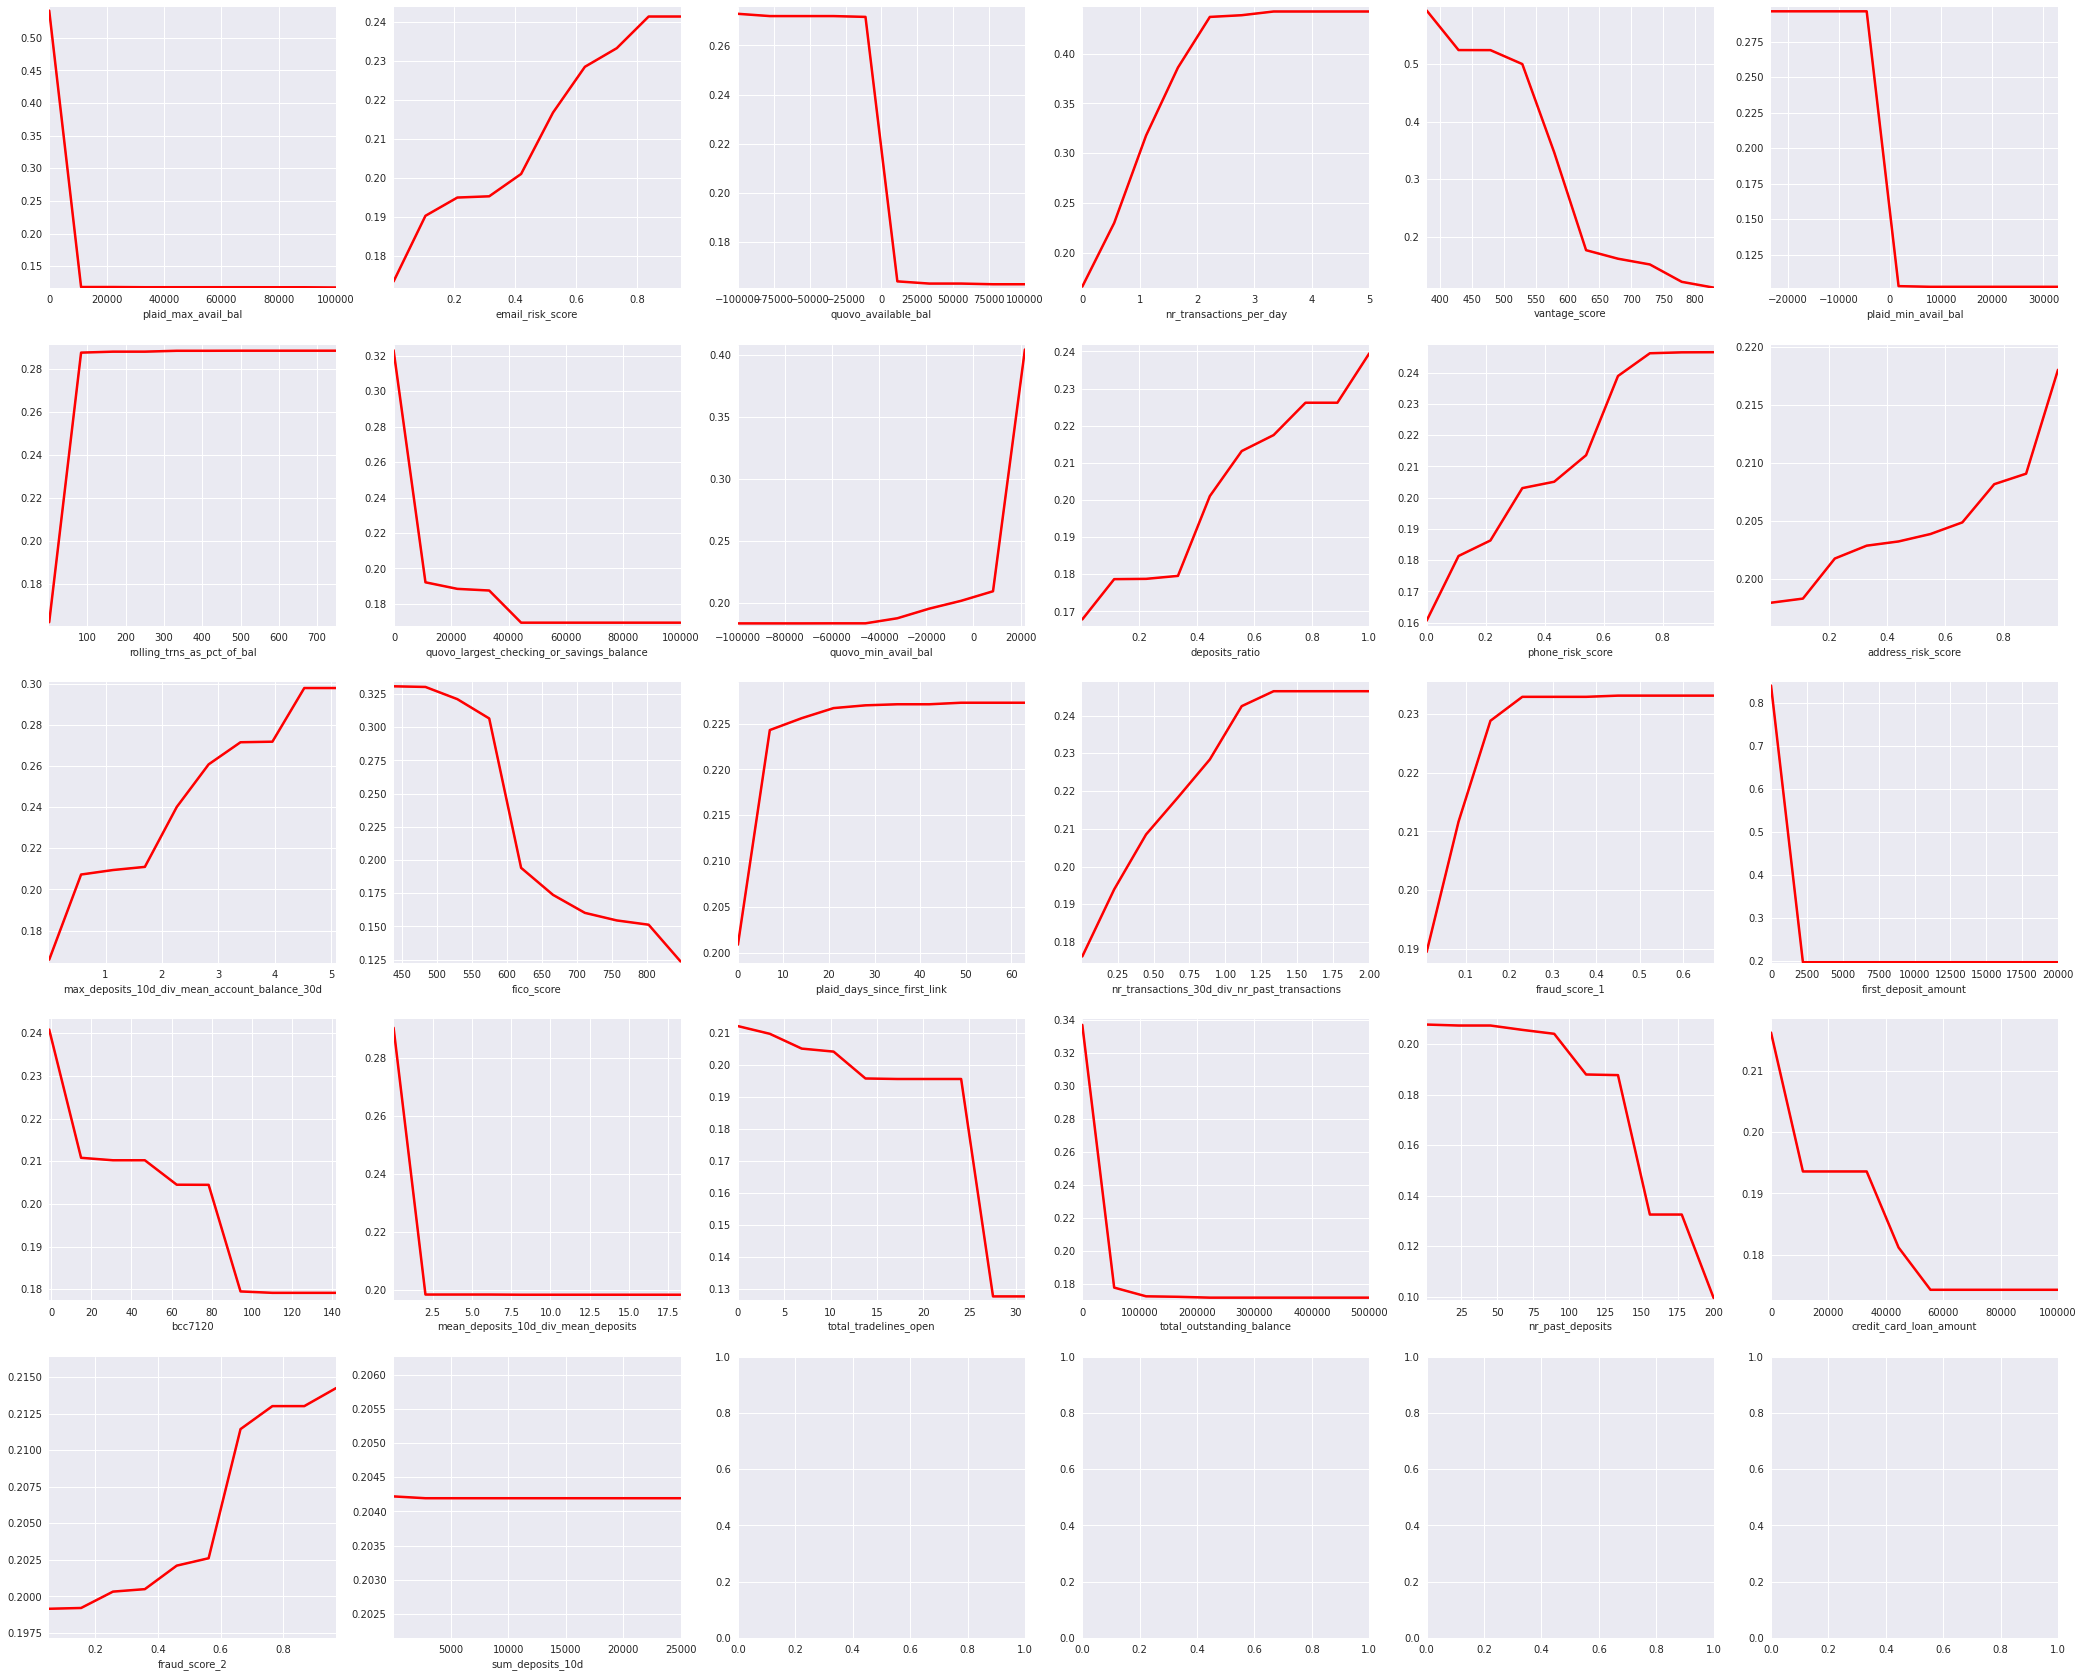

In [46]:
gvrn.save_pdp(clf, modeling_df, clf.feature_name_,
              features_by_imp, os.path.join(GOVN_PATH, "pdp"))

processed  26  num attributes

transformed num 20



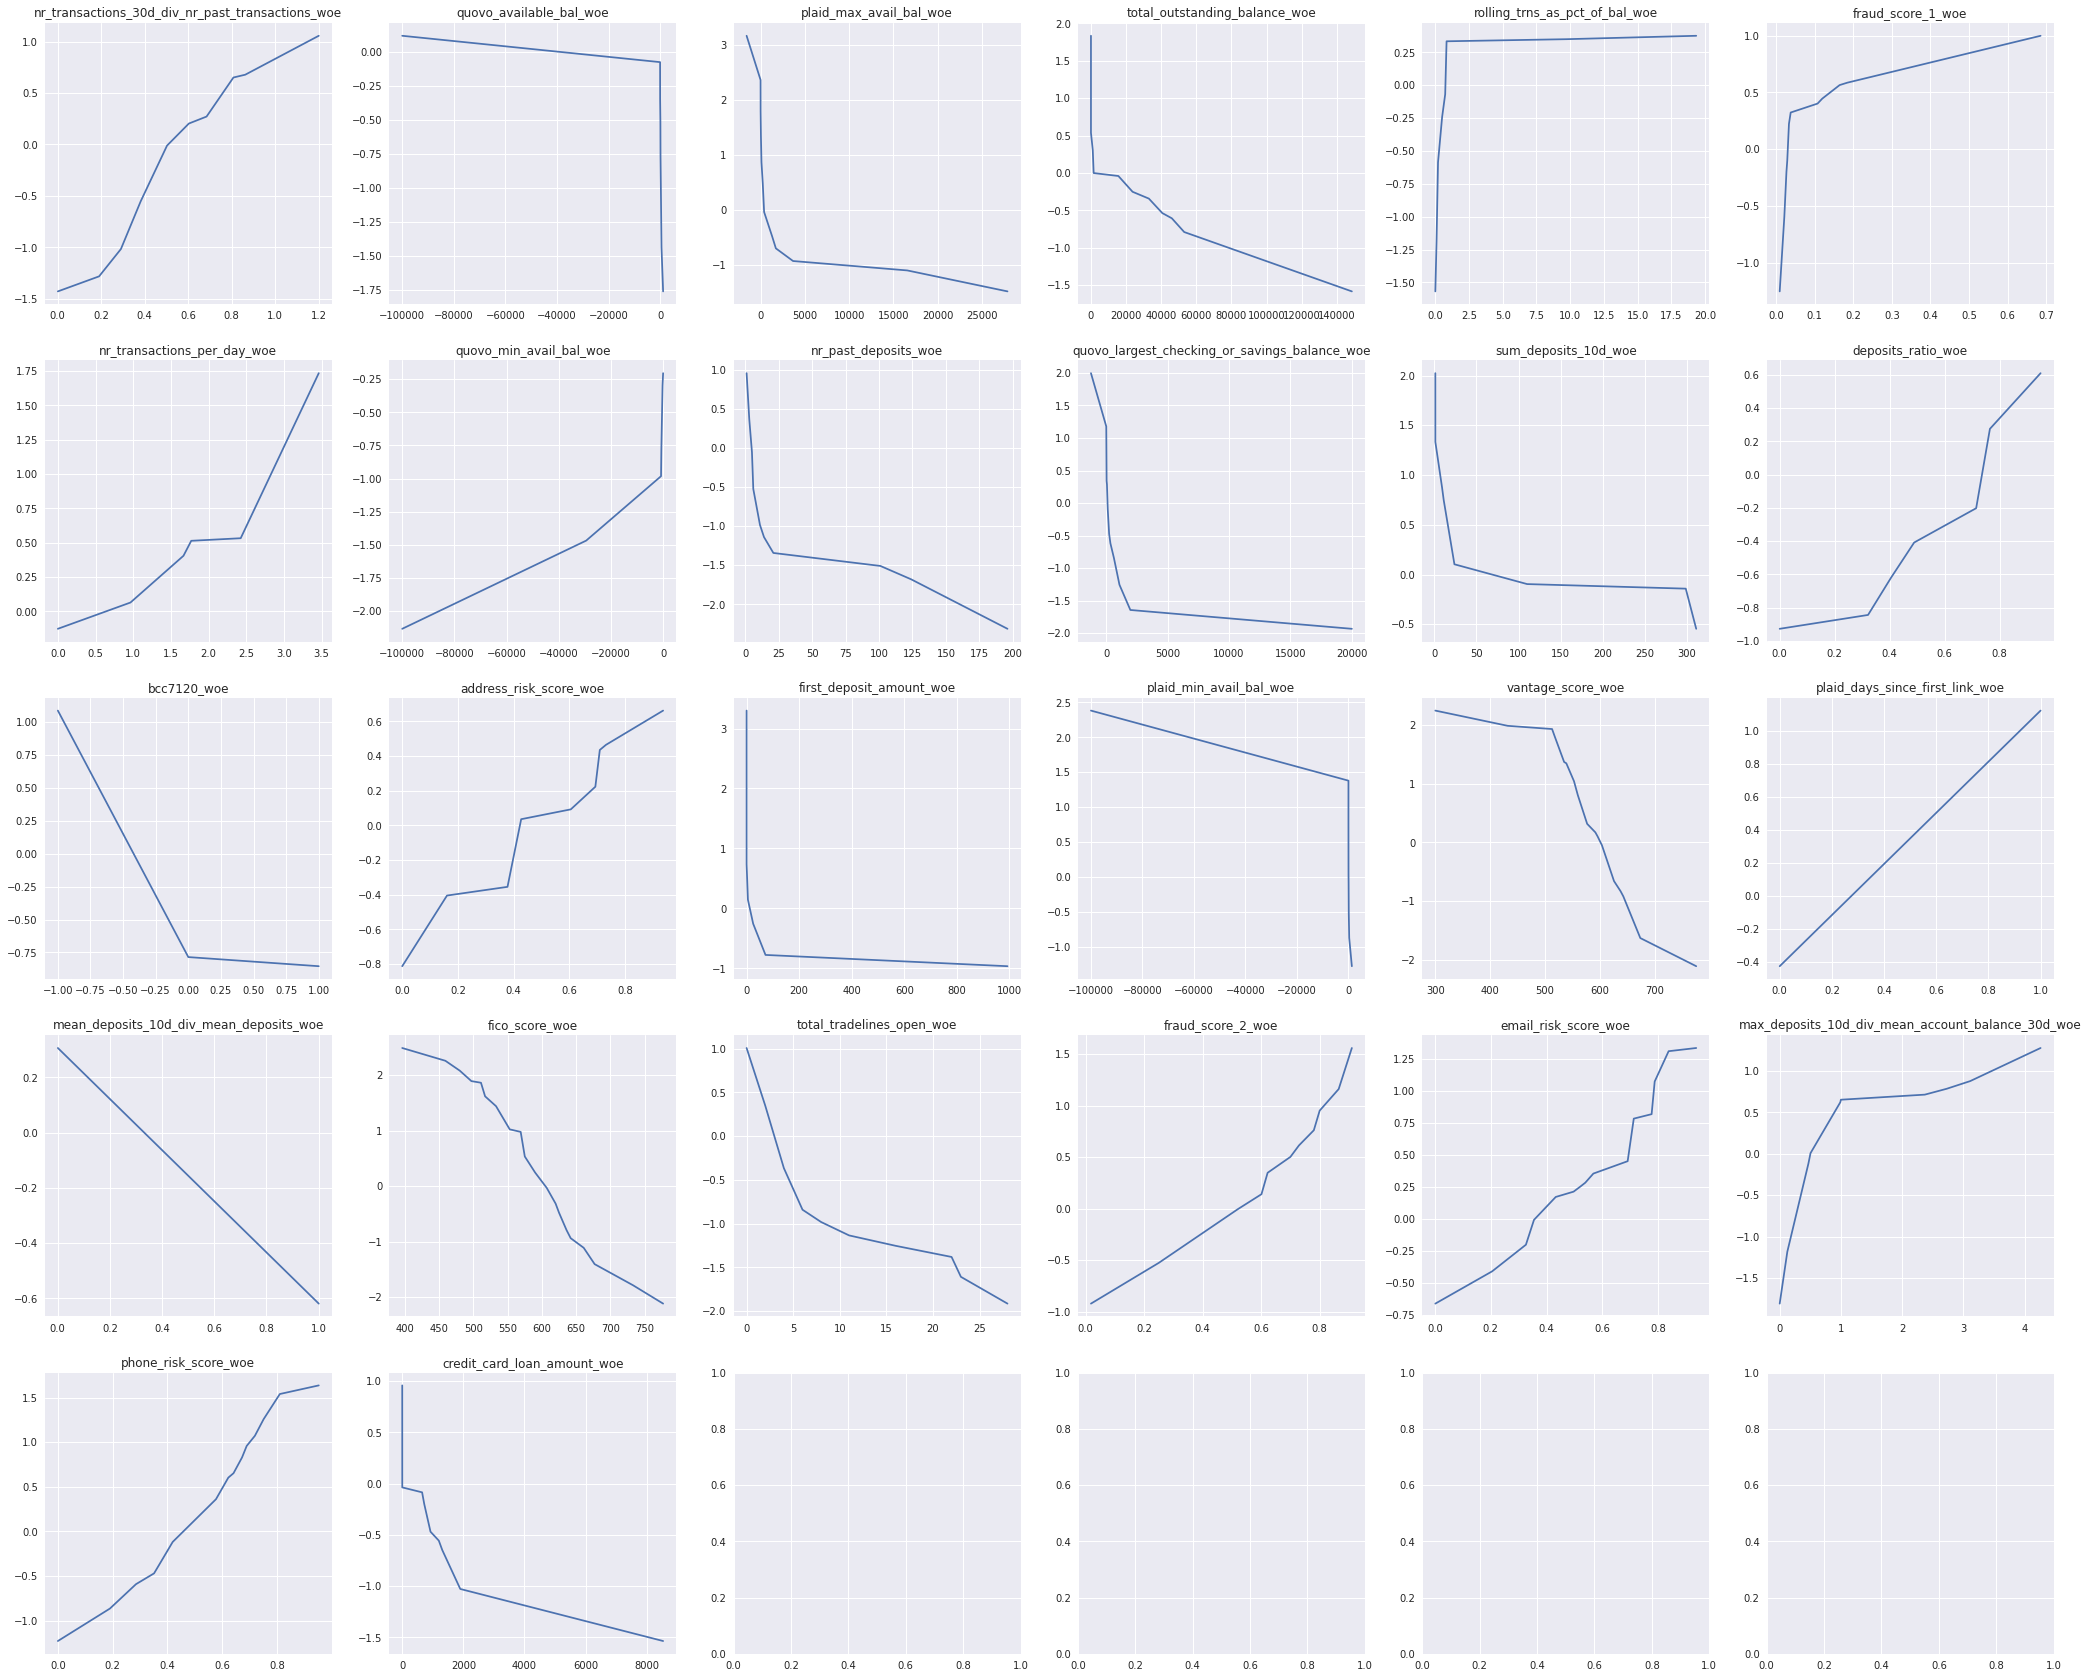

In [47]:
gvrn.save_woe_plots(modeling_df, TARGET_COL, features_by_imp, os.path.join(GOVN_PATH, "woe"))

In [48]:
gvrn.get_segmented_performances(valid_dfs, TARGET_COL, PRED_COLS, 
                                os.path.join(GOVN_PATH, "valid_segmented_performance"),
                                model_name="ach_deposit_v2")

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
